<div class="alert alert-block alert-info">
<h2> 2019 Data Science Bowl </h2>
</div>


PBS KIDS Measure Up! app, a game-based learning tool. In this Bowl the main goal is to gain insights into how media can help children learn important skills for success in school and life, predict scores on in-game assessments and create an algorithm that will lead to better-designed games.

The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):

* 3: the assessment was solved on the first attempt

* 2: the assessment was solved on the second attempt

* 1: the assessment was solved after 3 or more attempts

* 0: the assessment was never solved

Evaluation metric - **quadratic weighted kappa**.

Referance: The first place in this competition achived a score of 0.568 (the 100th place got a score of 0.547).

## In This Notebook :

- Data explorations
- feature engineering
- Data cleansing 
- Divide user into two groups - new & advanced
- Model each group seperately
    - Trying different methods dealing with class imbalanced
    - Group cross validation (by users id)
    - GridSearch for hyperparameters tuning
- Choosing the best performing model for predicting the test set

**Note:** The goal was the predict the last assessment result each user took. In order to maximize the information from the data set, for each assessment a user took I'll gather the previous data till that moment and add it as a new training set as for the target is known.

## Imports & File Upload

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
# from imblearn.over_sampling import SMOTENC
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix

pd.set_option('max_colwidth',300)
pd.options.display.max_rows = 2500

import pickle
import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
train.shape

(11341042, 11)

---

# Exploring The Data & Feature Engineering

In [3]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world
0,27253bdc,45bb1e1b6b50c07b,2019-09-06T17:53:46.937Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE
1,27253bdc,17eeb7f223665f53,2019-09-06T17:54:17.519Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK
2,77261ab5,0848ef14a8dc6892,2019-09-06T17:54:56.302Z,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK
3,b2dba42b,0848ef14a8dc6892,2019-09-06T17:54:56.387Z,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"",""media_type"":""audio"",""total_duration"":6758,""event_count"":2,""game_time"":53,""event_code"":3010}",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06T17:55:03.253Z,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"",""media_type"":""audio"",""duration"":6919,""event_count"":3,""game_time"":6972,""event_code"":3110}",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK


In [4]:
# reorder the columns in logical order

new_order = ['timestamp', 'installation_id', 'game_session', 'world', 'title', 'game_time', 'event_count', 'type' , 'event_code', 'event_id', 'event_data']
train = train.sort_values(['installation_id','timestamp'])

train = train.loc[:, new_order]

Removing users with no assessments (won't help assessing the user performance):

In [5]:
# according to the description, the event_code for assessments - 4110/4100

installation_with_ass = train.loc[(train.event_code==4100) | (train.event_code==4110),'installation_id'].unique()
len(installation_with_ass)

4248

In [6]:
#  installation ids with assessments

inst_with_ass = \
train.loc[(((train.title=='Bird Measurer (Assessment)') & (train.event_code==4110)) |
                ((train.title!='Bird Measurer (Assessment)') & (train.event_code==4100))
         & (train.type=='Assessment')),'installation_id'].unique()

In [7]:
train_with_ass = train.loc[train.installation_id.isin(inst_with_ass)]

In [8]:
train_with_ass.head()

,timestamp,installation_id,game_session,world,title,game_time,event_count,type,event_code,event_id,event_data
1538,2019-08-06T04:57:18.904Z,0006a69f,34ba1a28d02ba8ba,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}"
1539,2019-08-06T04:57:45.301Z,0006a69f,4b57c9a59474a1b9,MAGMAPEAK,Magma Peak - Level 1,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}"
1540,2019-08-06T04:58:14.538Z,0006a69f,2b9d5af79bcdb79f,MAGMAPEAK,Sandcastle Builder (Activity),0,1,Activity,2000,77261ab5,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}"
1541,2019-08-06T04:58:14.615Z,0006a69f,2b9d5af79bcdb79f,MAGMAPEAK,Sandcastle Builder (Activity),29,2,Activity,3010,b2dba42b,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"",""media_type"":""audio"",""total_duration"":6758,""event_count"":2,""game_time"":29,""event_code"":3010}"
1542,2019-08-06T04:58:16.680Z,0006a69f,2b9d5af79bcdb79f,MAGMAPEAK,Sandcastle Builder (Activity),2137,3,Activity,4070,1325467d,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":1015,""stage_height"":762},""event_count"":3,""game_time"":2137,""event_code"":4070}"


In [9]:
train_with_ass.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7734558 entries, 1538 to 11337825
Data columns (total 11 columns):
timestamp          object
installation_id    object
game_session       object
world              object
title              object
game_time          int64
event_count        int64
type               object
event_code         int64
event_id           object
event_data         object
dtypes: int64(3), object(8)
memory usage: 708.1+ MB


In [10]:
# converting to datetime format 

train_with_ass.timestamp = pd.to_datetime(train_with_ass.timestamp)
train_with_ass['date'] = train_with_ass.timestamp.dt.date
train_with_ass['time'] = train_with_ass.timestamp.dt.time

In [11]:
# size of new dataset

print(train.shape)
train_with_ass.shape

(11341042, 11)


(7734558, 13)

#### For ram saving reasons...
del train
gc.collect()

In [12]:
# total users in dataset

train_with_ass.installation_id.nunique()

3614

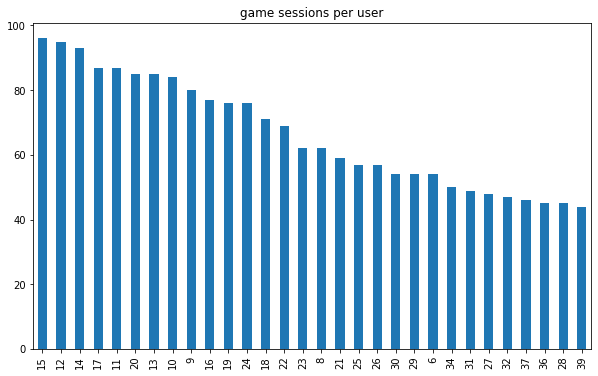

In [13]:
plt.figure(figsize=(10,6))
game_sessions = train_with_ass.groupby('installation_id')['game_session'].nunique().value_counts()
game_sessions.iloc[:30].plot(kind='bar')
plt.title('game sessions per user')
plt.show()

**210 users have less the 20 game sessions**

In [14]:
game_sessions.loc[game_sessions<20].count()

210

In [15]:
train_with_ass.groupby('installation_id')['game_session'].count().max()

58988

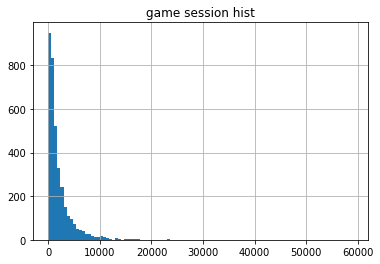

In [16]:
train_with_ass.groupby('installation_id')['game_session'].count().hist(bins=100)
plt.title('game session hist')
plt.show()

The data is highly right skewed. Most users had only few game sessions.

**I'll later divide the data to novice and advanced users.**
- novice = users with only one assessment completed
- advanced = users with more than one assessment completed

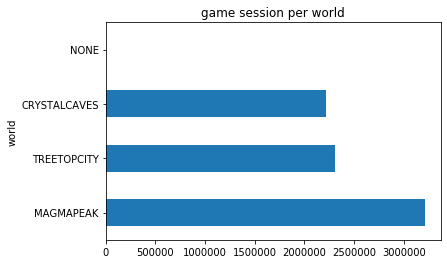

In [17]:
(train_with_ass
 .groupby('world')['game_session'].count()
 .sort_values(ascending=False)
 .plot(kind='barh', title='game session per world')
)
plt.show()

`MAGMAPEAK` is the most popular world. 

There's some game session with `NONE` world. I'll take a look at these rows.

In [18]:
print(train_with_ass.query("world=='NONE'").shape[0])
train_with_ass.query("world=='NONE'").head(10)

6938


,timestamp,installation_id,game_session,world,title,game_time,event_count,type,event_code,event_id,event_data,date,time
1538,2019-08-06 04:57:18.904000+00:00,0006a69f,34ba1a28d02ba8ba,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-08-06,04:57:18.904000
1774,2019-08-06 05:07:03.331000+00:00,0006a69f,4d566eabbefd780d,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-08-06,05:07:03.331000
3296,2019-08-06 17:42:59.589000+00:00,0006a69f,3b0a3935246e2b78,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-08-06,17:42:59.589000
4257,2019-08-09 18:21:26.440000+00:00,0006a69f,63909c20b822ffcc,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-08-09,18:21:26.440000
5339,2019-09-13 00:30:24.242000+00:00,0006c192,3e3ac29e618b6f0a,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-09-13,00:30:24.242000
5560,2019-09-14 00:01:01.270000+00:00,0006c192,6983be6646598935,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-09-14,00:01:01.270000
5562,2019-09-14 15:04:34.845000+00:00,0006c192,a9fbd6119581ac51,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-09-14,15:04:34.845000
6913,2019-09-20 13:04:42.601000+00:00,0006c192,246cb8a7316554a7,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-09-20,13:04:42.601000
10063,2019-09-05 13:52:48.101000+00:00,001d0ed0,07dce61ec6fd52ac,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-09-05,13:52:48.101000
11103,2019-10-05 23:48:27.823000+00:00,00225f67,fe34349639799cd6,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-10-05,23:48:27.823000


In [19]:
(train_with_ass.query("world=='NONE'").event_code==2000).all()

True

`NONE` world represent initial game window with a clip and `even_code` of 2000. I'll keep it as is.

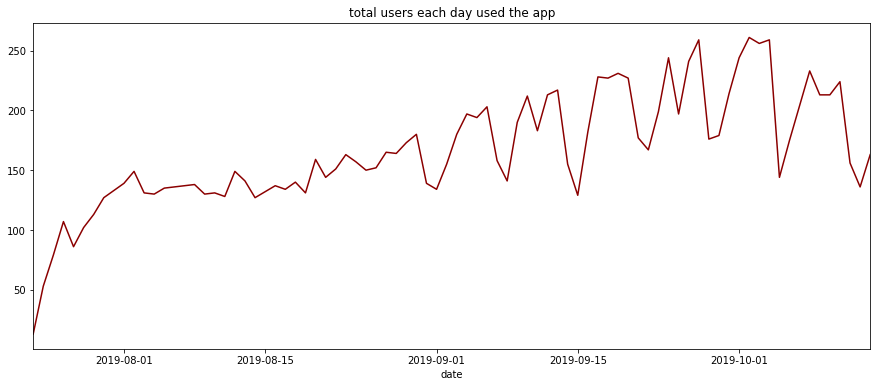

In [20]:
(train_with_ass
 .groupby('date')['installation_id'].nunique()
 .plot(kind='line', c='darkred',title='total users each day used the app', figsize=(15,6))
)
plt.show()

In general, There's an increasing use in the app. Some local (trend) decreases were detected, probably because of weekends.

## New Feature - Success\Failed in Assessment

In [21]:
ass_codes = (((train_with_ass.title=='Bird Measurer (Assessment)') & (train_with_ass.event_code==4110)) |
                ((train_with_ass.title!='Bird Measurer (Assessment)') & (train_with_ass.event_code==4100) & 
                 (train_with_ass.type=='Assessment')))

In [22]:
# total ass. events to train on:
train_with_ass.loc[ass_codes].shape

(41549, 13)

**Extracting the success\failed attribute from `event_data` columns:** 

In [23]:
train_with_ass.head(2)

,timestamp,installation_id,game_session,world,title,game_time,event_count,type,event_code,event_id,event_data,date,time
1538,2019-08-06 04:57:18.904000+00:00,0006a69f,34ba1a28d02ba8ba,NONE,Welcome to Lost Lagoon!,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-08-06,04:57:18.904000
1539,2019-08-06 04:57:45.301000+00:00,0006a69f,4b57c9a59474a1b9,MAGMAPEAK,Magma Peak - Level 1,0,1,Clip,2000,27253bdc,"{""event_code"": 2000, ""event_count"": 1}",2019-08-06,04:57:45.301000


In [24]:
event_data = train_with_ass.loc[(((train_with_ass.title=='Bird Measurer (Assessment)') & (train_with_ass.event_code==4110)) |
                ((train_with_ass.title!='Bird Measurer (Assessment)') & (train_with_ass.event_code==4100) & 
                 (train_with_ass.type=='Assessment'))),'event_data'].apply(lambda s: json.loads(s))

In [25]:
event_data.reset_index().join(pd.io.json.json_normalize(event_data).correct).set_index('index').drop(columns='event_data').head()

,correct
index,
2228,True
2709,False
2715,False
2720,False
2725,False


In [26]:
#  adding the new col as a feature in the main df

train_with_ass = train_with_ass.join(event_data.reset_index().join(pd.io.json.json_normalize(event_data).correct).set_index('index').drop(columns='event_data'))

In [27]:
# I won't be using event_data col anymore so I'll drop it

train_with_ass.drop(columns='event_data', inplace=True)

## Exploring Users Behavior:

In [28]:
# I'll use user id 'f90e8b6e' as a random example 

train_with_ass.loc[(train_with_ass.installation_id=='f90e8b6e') & ass_codes].head(100)

,timestamp,installation_id,game_session,world,title,game_time,event_count,type,event_code,event_id,date,time,correct
11042975,2019-07-24 14:59:45.428000+00:00,f90e8b6e,fa60dc6361ab2725,TREETOPCITY,Mushroom Sorter (Assessment),44056,82,Assessment,4100,25fa8af4,2019-07-24,14:59:45.428000,False
11043016,2019-07-24 15:00:37.407000+00:00,f90e8b6e,fa60dc6361ab2725,TREETOPCITY,Mushroom Sorter (Assessment),96043,123,Assessment,4100,25fa8af4,2019-07-24,15:00:37.407000,False
11043067,2019-07-24 15:02:47.036000+00:00,f90e8b6e,fa60dc6361ab2725,TREETOPCITY,Mushroom Sorter (Assessment),225669,174,Assessment,4100,25fa8af4,2019-07-24,15:02:47.036000,True
11043175,2019-07-25 14:48:52.676000+00:00,f90e8b6e,b3d7158e45f615fe,TREETOPCITY,Mushroom Sorter (Assessment),3420696,50,Assessment,4100,25fa8af4,2019-07-25,14:48:52.676000,True
11044455,2019-07-25 15:57:41.568000+00:00,f90e8b6e,b91447a995bc067d,CRYSTALCAVES,Cart Balancer (Assessment),12287,17,Assessment,4100,d122731b,2019-07-25,15:57:41.568000,False
11045020,2019-07-25 20:24:19.532000+00:00,f90e8b6e,3e9dc42c1558ca6e,CRYSTALCAVES,Chest Sorter (Assessment),44210,57,Assessment,4100,93b353f2,2019-07-25,20:24:19.532000,False
11045048,2019-07-25 20:24:36.232000+00:00,f90e8b6e,3e9dc42c1558ca6e,CRYSTALCAVES,Chest Sorter (Assessment),60912,85,Assessment,4100,93b353f2,2019-07-25,20:24:36.232000,False
11045070,2019-07-25 20:24:52.766000+00:00,f90e8b6e,3e9dc42c1558ca6e,CRYSTALCAVES,Chest Sorter (Assessment),77447,107,Assessment,4100,93b353f2,2019-07-25,20:24:52.766000,True
11047341,2019-07-26 00:00:20.023000+00:00,f90e8b6e,0ae4cd26e61a521b,MAGMAPEAK,Cauldron Filler (Assessment),7065,10,Assessment,4100,392e14df,2019-07-26,00:00:20.023000,False
11047424,2019-07-26 00:01:56.961000+00:00,f90e8b6e,0ae4cd26e61a521b,MAGMAPEAK,Cauldron Filler (Assessment),104006,93,Assessment,4100,392e14df,2019-07-26,00:01:56.961000,False


In [29]:
train_with_ass.loc[train_with_ass.installation_id=='554fc65a'].tail(2)

,timestamp,installation_id,game_session,world,title,game_time,event_count,type,event_code,event_id,date,time,correct
3899504,2019-09-23 23:26:04.086000+00:00,554fc65a,b219692dbec3cffe,MAGMAPEAK,Dino Drink,293506,131,Game,3021,77ead60d,2019-09-23,23:26:04.086000,NaN
3899505,2019-09-23 23:26:10.836000+00:00,554fc65a,b219692dbec3cffe,MAGMAPEAK,Dino Drink,300249,132,Game,3121,4d911100,2019-09-23,23:26:10.836000,NaN


## **User Statistics**

In [30]:
my_installation_id = 'f90e8b6e'

In [31]:
train_id = train_with_ass.loc[train_with_ass.installation_id==my_installation_id]
train_id.shape

(8629, 13)

In [32]:
ass_codes = [4100,4110]

In [33]:
# assessments the user took:
train_id.event_code.isin(ass_codes).sum()

20

In [34]:
# all user attepts:

train_id.loc[train_id.event_code.isin(ass_codes),['timestamp','correct']].head()

,timestamp,correct
11042975,2019-07-24 14:59:45.428000+00:00,False
11043016,2019-07-24 15:00:37.407000+00:00,False
11043067,2019-07-24 15:02:47.036000+00:00,True
11043175,2019-07-25 14:48:52.676000+00:00,True
11044455,2019-07-25 15:57:41.568000+00:00,False


In [35]:
# timestamp for the sec. assessment:

timestamp_ass = '2019-07-25 20:26:55.492000+00:00'

In [36]:
# subset of data till ass. timestamp:

train_id_time = train_id.loc[train_id.timestamp<timestamp_ass]
train_id_time.tail(5)

,timestamp,installation_id,game_session,world,title,game_time,event_count,type,event_code,event_id,date,time,correct
11045131,2019-07-25 20:26:52.318000+00:00,f90e8b6e,8ac3ed2151e7f16e,TREETOPCITY,Air Show,53299,49,Game,4070,bcceccc6,2019-07-25,20:26:52.318000,NaN
11045132,2019-07-25 20:26:52.598000+00:00,f90e8b6e,8ac3ed2151e7f16e,TREETOPCITY,Air Show,53583,50,Game,4070,bcceccc6,2019-07-25,20:26:52.598000,NaN
11045133,2019-07-25 20:26:53.048000+00:00,f90e8b6e,8ac3ed2151e7f16e,TREETOPCITY,Air Show,54033,51,Game,4070,bcceccc6,2019-07-25,20:26:53.048000,NaN
11045134,2019-07-25 20:26:53.349000+00:00,f90e8b6e,8ac3ed2151e7f16e,TREETOPCITY,Air Show,54333,52,Game,4070,bcceccc6,2019-07-25,20:26:53.349000,NaN
11045135,2019-07-25 20:26:53.796000+00:00,f90e8b6e,8ac3ed2151e7f16e,TREETOPCITY,Air Show,54783,53,Game,4070,bcceccc6,2019-07-25,20:26:53.796000,NaN


### User Assessment Accuracy Function

In [37]:
def true_attemp_num(correct):
    if sum(correct)==0:
        return 0
    else:
        return len(correct)

In [38]:
def group_score(attemp):
    if attemp > 2:
        return 1
    elif attemp >1:
        return 2
    elif attemp==1:
        return 3
    else:
        return 0

In [39]:
total_success = train_id_time.loc[(train_id_time.event_code.isin(ass_codes)) & (train_id_time.correct==True), 'correct'].sum()
total_tries = train_id_time.loc[(train_id_time.event_code.isin(ass_codes)) , 'correct'].shape[0]
accuracy_id = total_success / total_tries

In [40]:
total_success, total_tries, accuracy_id

(3, 8, 0.375)

### function for calculating the group_score

In [41]:
def label_group_score(id_time):
    
    ### this function calculates the group_score for df subset

    score_table = id_time.loc[(((train_with_ass.title=='Bird Measurer (Assessment)') & (train_with_ass.event_code==4110)) |
                ((train_with_ass.title!='Bird Measurer (Assessment)') & (train_with_ass.event_code==4100)& (train_with_ass.type=='Assessment')))].groupby(['date','title','game_session'])['correct'].agg(['count','sum']).reset_index()
    score_table['group_score'] = 0
    score_table['accuracy'] = 0

    for row in range(score_table.shape[0]):
        if score_table.loc[row,'sum']==0:
            pass
        elif score_table.loc[row,'count'] == 1:
            score_table.loc[row,'group_score'] = 3
            score_table.loc[row,'accuracy'] =  (1 / score_table.loc[row,'count'])
            
        elif score_table.loc[row,'count'] > 2:
            score_table.loc[row,'group_score'] = 1
            score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])
        else:
            score_table.loc[row,'group_score'] = 2
            score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])
            
    
    return score_table.groupby('title')['group_score','accuracy'].mean().reset_index()


# New Features - Users Stats

In [42]:
id_groups = train_with_ass.groupby('installation_id', sort=False)

In [43]:
# 180mins

df_id = []

for name, group in id_groups:
    ass_times = group.loc[(((group.title=='Bird Measurer (Assessment)') 
                            & (group.event_code==4110)) |
                ((group.title!='Bird Measurer (Assessment)') 
                 & (group.event_code==4100) & 
                 (group.type=='Assessment'))),'timestamp'].unique()
    
    prev_time = np.nan

    for time in ass_times:
        df_date_id = []
        id_time = group.loc[group.timestamp<time]
        ass = id_time.loc[(((id_time.title=='Bird Measurer (Assessment)') 
                                        & (id_time.event_code==4110)) |
                                            ((id_time.title!='Bird Measurer (Assessment)') 
                                             & (id_time.event_code==4100) & 
                                             (id_time.type=='Assessment')))]

#         total time spend in each game

        prev_game_per_date = id_time.loc[id_time.type=='Game'].groupby(['game_session','title'])['game_time'].max()
        total_game_time_id = prev_game_per_date.groupby('title').sum()
        total_game_time_id = total_game_time_id.to_frame().T
        total_game_time_id.index = [(name, time)] * len(total_game_time_id)
        total_game_time_id.columns = ['total_game_time_' + str(col) for col in total_game_time_id.columns]
        df_date_id.append(total_game_time_id)
        
#         total moves (events) completed in each game

        prev_game_moves_per_date = id_time.loc[id_time.type=='Game'].groupby(['game_session','title'])['event_count'].max()
        total_game_moves_id = prev_game_moves_per_date.groupby('title').sum()
        total_game_moves_id = total_game_moves_id.to_frame().T
        total_game_moves_id.index = [(name, time)] * len(total_game_moves_id)
        total_game_moves_id.columns = ['total_game_moves_' + str(col) for col in total_game_moves_id.columns]
        df_date_id.append(total_game_moves_id)

#         time spend in each activity

        prev_activity_per_date = id_time.loc[id_time.type=='Activity'].groupby(['game_session','title'])['game_time'].max()
        total_activity_time_id = prev_activity_per_date.groupby('title').sum()
        total_activity_time_id = total_activity_time_id.to_frame().T
        total_activity_time_id.index =[(name, time)] * len(total_activity_time_id)
        total_activity_time_id.columns = ['total_activity_time_' + str(col) for col in total_activity_time_id.columns]
        df_date_id.append(total_activity_time_id)
        
#         total moves (events) completed in each activity

        prev_activity_moves_per_date = id_time.loc[id_time.type=='Activity'].groupby(['game_session','title'])['event_count'].max()
        total_activity_moves_id = prev_activity_moves_per_date.groupby('title').sum()
        total_activity_moves_id = total_activity_moves_id.to_frame().T
        total_activity_moves_id.index = [(name, time)] * len(total_activity_moves_id)
        total_activity_moves_id.columns = ['total_activity_moves_' + str(col) for col in total_activity_moves_id.columns]
        df_date_id.append(total_activity_moves_id)
        
#         prev. time in ass

        if not(pd.isna(prev_time)) and \
        id_time.iloc[-1].game_session == group.loc[group.timestamp==prev_time,'game_session'].iloc[0]: 

            # another try in session
            prev_ass_per_date = group.loc[(group.type=='Assessment') &
                                          (group.timestamp<=prev_time)].groupby(['game_session','title'])['game_time'].max()
        else:
            # data untill the start of session
            start_session_time = id_time.loc[id_time.game_session==id_time.iloc[-1].game_session,'timestamp'].min() 
            prev_ass_per_date = group.loc[(group.type=='Assessment') &
                                      (group.timestamp<start_session_time)].groupby(['game_session','title'])['game_time'].max()

        total_ass_time_id = prev_ass_per_date.groupby('title').sum()
        total_ass_time_id = total_ass_time_id.to_frame().T
        total_ass_time_id.index = [(name, time)] * len(total_ass_time_id)
        total_ass_time_id.columns = ['total_ass_time_' + str(col) for col in total_ass_time_id.columns]
        df_date_id.append(total_ass_time_id)



#         total prev ass moves per game

        if not(pd.isna(prev_time)) and \
        id_time.iloc[-1].game_session == group.loc[group.timestamp==prev_time,'game_session'].iloc[0]: 
            prev_ass_moves_per_date = group.loc[(group.type=='Assessment') &
                                          (group.timestamp<=prev_time)].groupby(['game_session','title'])['event_count'].max()
        else:
            prev_ass_moves_per_date = group.loc[(group.type=='Assessment') &
                                              (group.timestamp<start_session_time)].groupby(['game_session','title'])['event_count'].max()

        total_ass_moves_id = prev_ass_moves_per_date.groupby('title').sum()
        total_ass_moves_id = total_ass_moves_id.to_frame().T
        total_ass_moves_id.index = [(name, time)] * len(total_ass_moves_id)
        total_ass_moves_id.columns = ['total_ass_moves_' + str(col) for col in total_ass_moves_id.columns]
        df_date_id.append(total_ass_moves_id)

#         total ass. took

        total_ass_took = id_time.loc[id_time.type=='Assessment'].groupby(['title'])['game_session'].nunique()
        total_ass_took_id = total_ass_took.groupby('title').sum()
        total_ass_took_id = total_ass_took_id.to_frame().T
        total_ass_took_id[id_time.title.iloc[-1]] -= 1 # not including the current ass. session
        total_ass_took_id.index = [(name, time)] * len(total_ass_took_id)
        total_ass_took_id.columns = ['total_ass_took_' + str(col) for col in total_ass_took_id.columns]
        df_date_id.append(total_ass_took_id)
        
#         total_days

        total_active_days = pd.DataFrame(data={(name, time):[id_time.date.nunique()]}).T.rename(columns={0:'total_active_days'})
        df_date_id.append(total_active_days)
                
#         clips

        total_clips = pd.DataFrame(data={(name, time):[id_time.loc[id_time.type=='Clip'].shape[0]]}).T.rename(columns={0:'total_clips'})
        df_date_id.append(total_clips)

#         cumsum game accuracy

        total_success = ass.loc[ass.correct==True, 'correct'].sum()
                                   
        total_tries = ass.shape[0]
        if total_tries==0:
            average_accuracy_score = 0
        else:
            average_accuracy_score = total_success / total_tries
        average_accuracy = pd.DataFrame(data={(name, time):[average_accuracy_score]}).T.rename(columns={0:'cumsum_accuracy'})
        df_date_id.append(average_accuracy)        

#         total attempts per game

        if ass.shape[0]>0:
            attemps = ass.groupby(['title','game_session'])['correct'].count().groupby('title')
            total_attemp = attemps.sum()
            total_attemp_df = total_attemp.to_frame().T
            total_attemp_df.index = [(name, time)] * len(total_attemp_df)
            total_attemp_df.columns = ['total_attempts_' + str(col) for col in total_attemp_df.columns]
            df_date_id.append(total_attemp_df)        
        else:
            pass
        
        
#         average group_score by title

        if ass.shape[0]>0:
            avg_group_score = ass.groupby(['title','game_session'])['correct'].agg(true_attemp_num).apply(group_score)\
            .groupby('title').mean().to_frame().T
            avg_group_score.index = [(name, time)] * len(avg_group_score)
            avg_group_score.columns = ['avg_group_score_' + str(col) for col in avg_group_score.columns]
            df_date_id.append(avg_group_score) 
        else:
            pass
        
#         max_group_score

        if ass.shape[0]>0:
            max_group_score = ass.groupby(['title','game_session'])['correct'].agg(true_attemp_num).apply(group_score)\
            .groupby('title').max().to_frame().T
            max_group_score.index = [(name, time)] * len(max_group_score)
            max_group_score.columns = ['max_group_score_' + str(col) for col in max_group_score.columns]
            df_date_id.append(max_group_score) 
        else:
            pass

#         prev_game_scores

        score_table = ass.groupby(['world','title','game_session'])['correct'].agg(['count','sum']).reset_index()
        score_table['group_score'] = 0
        score_table['accuracy'] = 0

        for row in range(score_table.shape[0]):
            if score_table.loc[row,'sum']==0:
                continue
            elif score_table.loc[row,'count'] == 1:
                score_table.loc[row,'group_score'] = 3
                score_table.loc[row,'accuracy'] =  (1 / score_table.loc[row,'count'])

            elif score_table.loc[row,'count'] > 2:
                score_table.loc[row,'group_score'] = 1
                score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])
            else:
                score_table.loc[row,'group_score'] = 2
                score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])

        
#         average game accuracy

        group_accuracy_prev_games = score_table.groupby('title')['group_score','accuracy'].mean().T.iloc[1].to_frame().T
        group_accuracy_prev_games.index = [(name, time)] * len(group_accuracy_prev_games)
        group_accuracy_prev_games.columns = ['avg_accuracy_prev_games_' + str(col) for col in group_accuracy_prev_games.columns]
        df_date_id.append(group_accuracy_prev_games) 
        
#         total successes in prev. games

        total_wins_prev_games = score_table.groupby('title')['sum'].sum().to_frame().T
        total_wins_prev_games.index = [(name, time)] * len(total_wins_prev_games)
        total_wins_prev_games.columns = ['total_wins_prev_games_' + str(col) for col in total_wins_prev_games.columns]
        df_date_id.append(total_wins_prev_games) 
        
#         title group accuracy history

        total_group_score_games = score_table.groupby(['title','group_score'])['game_session'].count().to_frame().T
        total_group_score_games.columns = [col[0]+'_group_'+str(col[1]) for col in total_group_score_games.columns.values]
        total_group_score_games.index = [(name, time)] * len(total_wins_prev_games)
        df_date_id.append(total_group_score_games) 
            
#          total group accuracy history

        total_group_history = score_table.groupby('group_score')['title'].count().to_frame().T
        total_group_history.columns = ['group_'+str(col)+'_count' for col in total_group_history.columns.values]
        total_group_history.index = [(name, time)] * len(total_group_history)
        df_date_id.append(total_group_history) 
#   
#          accuracy in world ass.

        avg_world_accuracy = score_table.groupby('world')['accuracy'].mean().to_frame().T
        avg_world_accuracy.index = [(name, time)] * len(avg_world_accuracy)
        avg_world_accuracy.columns = ['avg_accuracy_world_' + str(col) for col in avg_world_accuracy.columns]
        df_date_id.append(avg_world_accuracy)
    
#         group in world ass.

        avg_world_group = score_table.groupby('world')['group_score'].mean().to_frame().T
        avg_world_group.index = [(name, time)] * len(avg_world_group)
        avg_world_group.columns = ['avg_group_world_' + str(col) for col in avg_world_group.columns]
        df_date_id.append(avg_world_group)    
    
#           games in world

        world_games = id_time.loc[(id_time.world!='NONE') & 
                          (id_time.type=='Game')].groupby(['world'])['game_session'].nunique().to_frame().T
        world_games.columns = ['total_games_'+str(col)+'_world' for col in world_games.columns.values]
        world_games.index = [(name, time)] * len(world_games)
        df_date_id.append(world_games) 

#         activities in world

        world_activity = id_time.loc[(id_time.world!='NONE') & 
                                  (id_time.type=='Activity')].groupby(['world'])['game_session'].nunique().to_frame().T
        world_activity.columns = ['total_activities_'+str(col)+'_world' for col in world_activity.columns.values]
        world_activity.index = [(name, time)] * len(world_activity)
        df_date_id.append(world_activity) 
        
        # first attemp in title
        
        prev_game_scores = score_table.groupby('title')['group_score','accuracy'].mean()
        if prev_game_scores.shape[0]>0:
            first_attempt = ~pd.DataFrame(prev_game_scores.index.str.contains(id_time.title.iloc[-1], regex=False)).any()
            first_attempt.index = [(name, time)] * len(first_attempt)
            first_attempt.name = 'first_attempt'
            df_date_id.append(first_attempt) 
        else:
            df_date_id.append(pd.DataFrame([True], columns=['first_attempt'], index=[(name, time)]))
            
#         first attempt ever

        if ass.shape[0]==0:
            df_date_id.append(pd.DataFrame([True], columns=['first_ass'], index=[(name, time)]))
        else:
            df_date_id.append(pd.DataFrame([False], columns=['first_ass'], index=[(name, time)]))

            
#         event codes counter

        if not(pd.isna(prev_time)) and \
                    id_time.iloc[-1].game_session == group.loc[group.timestamp==prev_time,'game_session'].iloc[0]: #if it's another try in ass.    
            event_codes_per_date = group.loc[group.timestamp<=prev_time,'event_code'].value_counts().to_frame().T
        else:
            event_codes_per_date = id_time.loc[id_time.timestamp <= start_session_time,'event_code'].value_counts().to_frame().T

        event_codes_per_date.index = [(name, time)] * len(event_codes_per_date)
        event_codes_per_date.columns = ['event_code_' + str(col) for col in event_codes_per_date.columns]
        df_date_id.append(event_codes_per_date)


#         event id counter

        if not(pd.isna(prev_time)) and \
                    id_time.iloc[-1].game_session == group.loc[group.timestamp==prev_time,'game_session'].iloc[0]: #if it's another try in ass.    
            event_id_per_date = group.loc[group.timestamp<=prev_time,'event_id'].value_counts().to_frame().T
        else:
            event_id_per_date = id_time.loc[id_time.timestamp <= start_session_time,'event_id'].value_counts().to_frame().T
        
        try:
            event_id_per_date.drop(columns='27253bdc', inplace=True) # similar to clip counter
        except:
            pass
        event_id_per_date.index = [(name, time)] * len(event_id_per_date)
        event_id_per_date.columns = ['event_code_' + str(col) for col in event_id_per_date.columns]
        df_date_id.append(event_id_per_date)

        
        prev_time = time
        df_id.append(pd.concat(df_date_id, axis=1))


In [49]:
col_list = []
for df in df_id:
    col_list.extend(df.columns.tolist())
col_list = set(col_list)

print(len(col_list))

538


In [50]:
for i in range(len(df_id)):
    for col in col_list:
        if col in df_id[i].columns:
            pass
        else:
            df_id[i][col] = 0

In [51]:
main_features = pd.concat(df_id).reset_index()
main_features['installation_id'] = main_features['index'].apply(lambda i: i[0])
main_features['timestamp'] = main_features['index'].apply(lambda i: i[1])
main_features.fillna(0, inplace=True)
print(main_features.shape)
main_features.sample(4)

(41549, 541)


,index,Bird Measurer (Assessment)_group_0,Bird Measurer (Assessment)_group_1,Bird Measurer (Assessment)_group_2,Bird Measurer (Assessment)_group_3,Cart Balancer (Assessment)_group_0,Cart Balancer (Assessment)_group_1,Cart Balancer (Assessment)_group_2,Cart Balancer (Assessment)_group_3,Cauldron Filler (Assessment)_group_0,...,total_games_CRYSTALCAVES_world,total_games_MAGMAPEAK_world,total_games_TREETOPCITY_world,total_wins_prev_games_Bird Measurer (Assessment),total_wins_prev_games_Cart Balancer (Assessment),total_wins_prev_games_Cauldron Filler (Assessment),total_wins_prev_games_Chest Sorter (Assessment),total_wins_prev_games_Mushroom Sorter (Assessment),installation_id,timestamp
41172,"(fc2aa3b2, 2019-10-02 19:06:50.986000+00:00)",1,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,True,fc2aa3b2,2019-10-02 19:06:50.986000+00:00
15257,"(55fdf49f, 2019-09-21 20:47:30.414000+00:00)",1,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,True,55fdf49f,2019-09-21 20:47:30.414000+00:00
12804,"(4b85deb2, 2019-09-14 19:04:08.036000+00:00)",0,1,0,0,0,0,0,1,0,...,0,1,0,1,True,0,1,0,4b85deb2,2019-09-14 19:04:08.036000+00:00
29691,"(b6050bfe, 2019-10-06 22:25:27.134000+00:00)",0,0,0,0,0,0,0,0,0,...,22,4,5,0,0,2,0,2,b6050bfe,2019-10-06 22:25:27.134000+00:00


**Saving Checkpoint**

In [65]:
with open('main_features.pickle', 'wb') as f:
    pickle.dump(main_features, f, pickle.HIGHEST_PROTOCOL)

In [66]:
with open('main_features.pickle', 'rb') as f:
    main_features = pickle.load(f)

del df_id
gc.collect()

# Game Statistics Features

In [67]:
score_table

,title,game_session,count,sum,group_score,accuracy,success_rate
0,Bird Measurer (Assessment),0014403daadf67aa,4,1,1,0.25,1
1,Bird Measurer (Assessment),001c49e9e9968dbe,2,1,2,0.50,1
2,Bird Measurer (Assessment),002396a496a0c1c7,1,True,3,1.00,1
3,Bird Measurer (Assessment),0024681d73e46aca,1,False,0,0.00,0
4,Bird Measurer (Assessment),0060b5da47c841d3,1,True,3,1.00,1
...,...,...,...,...,...,...,...
17685,Mushroom Sorter (Assessment),ffde5ebf5d6df684,1,True,3,1.00,1
17686,Mushroom Sorter (Assessment),ffe06fe14beb0276,1,True,3,1.00,1
17687,Mushroom Sorter (Assessment),ffe4149114747eb7,2,1,2,0.50,1
17688,Mushroom Sorter (Assessment),ffe43e55c3f6a209,2,1,2,0.50,1


In [68]:
score_table = train_with_ass.loc[(((train_with_ass.title=='Bird Measurer (Assessment)') & (train_with_ass.event_code==4110)) |
                ((train_with_ass.title!='Bird Measurer (Assessment)') & 
                 (train_with_ass.event_code==4100) &
                 (train_with_ass.type=='Assessment')))].groupby(['title','game_session'])['correct'].agg(['count','sum']).reset_index()

score_table['group_score'] = 0
score_table['accuracy'] = 0
score_table['success_rate'] = 1

for row in range(score_table.shape[0]):
    if score_table.loc[row,'sum']==0:  # mission did not completed
        score_table.loc[row,'success_rate'] = 0
    elif score_table.loc[row,'count'] == 1:
        score_table.loc[row,'group_score'] = 3
        score_table.loc[row,'accuracy'] =  (1 / score_table.loc[row,'count'])

    elif score_table.loc[row,'count'] > 2:
        score_table.loc[row,'group_score'] = 1
        score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])
    else:
        score_table.loc[row,'group_score'] = 2
        score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])


game_stats =  score_table.groupby('title')['group_score','accuracy','success_rate'].agg({
    'group_score':'mean','accuracy':'mean','success_rate':['sum','count']
    }).reset_index()


In [69]:
game_stats['success_rate'] = (game_stats['success_rate']['sum']) / game_stats['success_rate']['count']

In [70]:
game_stats.columns = game_stats.columns.droplevel(1)
game_stats = game_stats.T.drop_duplicates().T.set_index('title')

In [71]:
game_stats.group_score = game_stats.group_score.astype(float)
game_stats.accuracy = game_stats.accuracy.astype(float)
game_stats.success_rate = game_stats.success_rate.astype(float)

In [72]:
game_stats.corr()

,group_score,accuracy,success_rate
group_score,1.000000,0.998991,0.971444
accuracy,0.998991,1.000000,0.959823
success_rate,0.971444,0.959823,1.000000


In [73]:
#  I'll drop group_score attribute because od high correaltion with accuracy

game_stats.drop(columns=['group_score'], inplace=True)

In [74]:
game_stats

,accuracy,success_rate
title,,
Bird Measurer (Assessment),0.387379,0.677349
Cart Balancer (Assessment),0.742232,0.861238
Cauldron Filler (Assessment),0.735537,0.896178
Chest Sorter (Assessment),0.248625,0.412278
Mushroom Sorter (Assessment),0.711042,0.841895


# **Game Overall Success Rate** 

In [75]:
overall_success = train_with_ass.loc[(((train_with_ass.title=='Bird Measurer (Assessment)') & 
                                       (train_with_ass.event_code==4110)) |
                ((train_with_ass.title!='Bird Measurer (Assessment)') & (train_with_ass.event_code==4100)& 
                 (train_with_ass.type=='Assessment')))].pivot_table(index='title',
                                                                    columns='correct',
                                                                    values='type',
                                                                    aggfunc='count')
overall_success = overall_success.reset_index()
overall_success

correct,title,False,True
0,Bird Measurer (Assessment),9298,1860
1,Cart Balancer (Assessment),3122,3575
2,Cauldron Filler (Assessment),3834,3634
3,Chest Sorter (Assessment),8738,1229
4,Mushroom Sorter (Assessment),3096,3163


In [76]:
overall_success.set_index('title', inplace=True)
overall_success['success_rate'] = overall_success[True] / (overall_success[True] + overall_success[False])

In [77]:
# adding overall success rate to the game statistics

overall_success_rate = overall_success.success_rate
overall_success_rate.name = 'overall_success_rate'
game_stats = game_stats.join(overall_success_rate)

In [78]:
game_stats.corr()

,accuracy,success_rate,overall_success_rate
accuracy,1.000000,0.959823,0.987182
success_rate,0.959823,1.000000,0.904382
overall_success_rate,0.987182,0.904382,1.000000


For now I'll keep all features eventhough the high correlation.

# Calculating Train Label
The train label wasn't calculated for the test set so I'll bulid the function to calculate the target label and use it also for the train set.

In [79]:
def label_group_score(installaion_group):
    
    ### function for calculating the group_score by df
    ### input: installaion_group
    ### output: accuracy_group

    local_df = installaion_group.loc[(((installaion_group.title=='Bird Measurer (Assessment)') & (installaion_group.event_code==4110)) |
                ((installaion_group.title!='Bird Measurer (Assessment)') & (installaion_group.event_code==4100)&
                 (installaion_group.type=='Assessment')))]
    score_table = local_df.groupby(['title','game_session'])['correct'].agg(['count','sum']).reset_index()

    scores = [0 for row in range(len(score_table))]
    for row in range(len(score_table)):
        if score_table.loc[row,'sum']==0:
            scores[row] = 0
        elif score_table.loc[row,'count'] == 1:
            scores[row] = 3
        elif score_table.loc[row,'count'] > 2:
            scores[row] = 1
        else:
            scores[row] = 2
    score_table['accuracy_group'] = pd.Series(scores)
    score_table.set_index('game_session', inplace=True)
    return score_table['accuracy_group']

In [80]:
ins_groups = train_with_ass.groupby(['installation_id'])
accuracy_group = []
for name, group in ins_groups:
    accuracy_group.append(label_group_score(group))

In [81]:
accuracy_group = pd.concat(accuracy_group)

In [82]:
accuracy_group[:5]

game_session
77b8ee947eb84b4e    0
a9ef3ecb3d1acc6a    3
6bdf9623adc94d89    3
901acc108f55a5a1    3
9501794defd84e4d    2
Name: accuracy_group, dtype: int64

# Constructing The Training Dataset

In [83]:
train_agg = train_with_ass.loc[(((train_with_ass.title=='Bird Measurer (Assessment)') 
                                        & (train_with_ass.event_code==4110)) |
                                            ((train_with_ass.title!='Bird Measurer (Assessment)') 
                                             & (train_with_ass.event_code==4100)& 
                                             (train_with_ass.type=='Assessment')))]

In [84]:
train_agg = train_agg.merge(main_features, how='left', left_on=['timestamp','installation_id'],
             right_on=['timestamp','installation_id'])

In [85]:
train_agg = train_agg.merge(game_stats, left_on='title', right_index=True,
                             how='left')

In [86]:
train_agg = train_agg.merge(accuracy_group, left_on='game_session', right_index=True,
                             how='left')

### New Features - Hour of Day & Weekday
**I'll use these attributes as (cyclical) features**

In [87]:
train_agg.drop(columns=['time','date'],inplace=True)
train_agg['weekday'] = train_agg.timestamp.dt.weekday
train_agg['hour_of_day'] = train_agg.timestamp.dt.hour

In [88]:
train_agg['sin_time'] = np.sin(2 * np.pi * train_agg.hour_of_day/24)
train_agg['cos_time'] = np.cos(2 * np.pi * train_agg.hour_of_day/24)
train_agg['sin_weekday'] = np.sin(2 * np.pi * train_agg.weekday/7)
train_agg['cos_weekday'] = np.cos(2 * np.pi * train_agg.weekday/7)

train_agg.drop(columns=['hour_of_day','weekday'], inplace=True)

In [89]:
train_agg_clean = train_agg.drop(columns=['timestamp', 'game_session',
                                        'type','index', 'correct',
                                         'event_code','event_id',
                                         'event_count','game_time'])

train_agg_clean.shape

(41549, 549)

## Converting Categorical Features Into Numeric

In [90]:
train_agg_clean.dtypes

installation_id                                          object
world                                                    object
title                                                    object
Bird Measurer (Assessment)_group_0                        int64
Bird Measurer (Assessment)_group_1                        int64
Bird Measurer (Assessment)_group_2                        int64
Bird Measurer (Assessment)_group_3                        int64
Cart Balancer (Assessment)_group_0                        int64
Cart Balancer (Assessment)_group_1                        int64
Cart Balancer (Assessment)_group_2                        int64
Cart Balancer (Assessment)_group_3                        int64
Cauldron Filler (Assessment)_group_0                      int64
Cauldron Filler (Assessment)_group_1                      int64
Cauldron Filler (Assessment)_group_2                      int64
Cauldron Filler (Assessment)_group_3                      int64
Chest Sorter (Assessment)_group_0       

In [91]:
# converting into the right dtype

train_agg_clean['total_wins_prev_games_Bird Measurer (Assessment)'] = train_agg_clean['total_wins_prev_games_Bird Measurer (Assessment)'].astype(int)
train_agg_clean['total_wins_prev_games_Cart Balancer (Assessment)'] = train_agg_clean['total_wins_prev_games_Cart Balancer (Assessment)'].astype(int)
train_agg_clean['total_wins_prev_games_Cauldron Filler (Assessment)'] = train_agg_clean['total_wins_prev_games_Cauldron Filler (Assessment)'].astype(int)
train_agg_clean['total_wins_prev_games_Chest Sorter (Assessment)'] = train_agg_clean['total_wins_prev_games_Chest Sorter (Assessment)'].astype(int)
train_agg_clean['total_wins_prev_games_Mushroom Sorter (Assessment)'] = train_agg_clean['total_wins_prev_games_Mushroom Sorter (Assessment)'].astype(int)

In [118]:
print(train_agg_clean.shape)
train_agg_clean_dummies = pd.get_dummies(train_agg_clean, columns=['world','title'])
train_agg_clean_dummies.shape

(41549, 549)


(41549, 555)

**checking for high correlation between features:**

In [121]:
train_with_ass.loc[(((train_with_ass.title=='Bird Measurer (Assessment)') 
                                        & (train_with_ass.event_code==4110)) |
                                            ((train_with_ass.title!='Bird Measurer (Assessment)') 
                                             & (train_with_ass.event_code==4100) & 
                                             (train_with_ass.type=='Assessment')))].groupby(['world','title'])['title'].nunique()

world         title                       
CRYSTALCAVES  Cart Balancer (Assessment)      1
              Chest Sorter (Assessment)       1
MAGMAPEAK     Cauldron Filler (Assessment)    1
TREETOPCITY   Bird Measurer (Assessment)      1
              Mushroom Sorter (Assessment)    1
Name: title, dtype: int64

In [122]:
corr_matrix = train_agg_clean_dummies.corr().abs().unstack().reset_index().sort_values(0, ascending=False)
corr_matrix.loc[corr_matrix.level_0 != corr_matrix.level_1].head(20)

,level_0,level_1,0
99145,event_code_45d01abe,total_wins_prev_games_Bird Measurer (Assessment),1.0
97791,event_code_4235,event_code_85de926c,1.0
97301,event_code_4230,event_code_ad148f58,1.0
96453,event_code_4220,event_code_1340b8d7,1.0
110497,event_code_5010,event_code_71e712d8,1.0
110032,event_code_5000,event_code_a6d66e51,1.0
92847,event_code_4050,event_code_a1192f43,1.0
90374,event_code_4031,event_code_1996c610,1.0
141032,event_code_736f9581,event_code_9b23e8ee,1.0
139253,event_code_71e712d8,event_code_5010,1.0


In [123]:
# set on cols appears only once
high_corr_matrix = corr_matrix.loc[(corr_matrix[0]>0.997) & (corr_matrix.level_0 > corr_matrix.level_1)]
high_corr_matrix.shape

(165, 3)

In [124]:
cols_to_remove_corr = high_corr_matrix.level_1.tolist()
cols_to_remove_corr[:6]

['event_code_1340b8d7',
 'event_code_1996c610',
 'event_code_5010',
 'event_code_222660ff',
 'avg_group_score_Cauldron Filler (Assessment)',
 'avg_accuracy_prev_games_Cauldron Filler (Assessment)']

In [125]:
train_agg_clean_dummies.drop(columns=cols_to_remove_corr, inplace=True)

In [126]:
model_col_list = train_agg_clean_dummies.columns

del train_agg
del train_agg_clean
del train_with_ass
del corr_matrix

gc.collect()

# Scoring Function

In [127]:
def reg_to_class(y_pred):
    y_pred_class = []
    for y in y_pred:
        if y<0:
            y_pred_class.append(0)
        elif y>3:
            y_pred_class.append(3)
        else:
            y_pred_class.append(round(y,0))
    return np.array(y_pred_class)

# Modeling

In [129]:
train_agg_clean_dummies.head(2)

,installation_id,Bird Measurer (Assessment)_group_0,Bird Measurer (Assessment)_group_1,Bird Measurer (Assessment)_group_2,Bird Measurer (Assessment)_group_3,Cart Balancer (Assessment)_group_0,Cart Balancer (Assessment)_group_1,Cart Balancer (Assessment)_group_2,Cart Balancer (Assessment)_group_3,Cauldron Filler (Assessment)_group_0,...,cos_time,sin_weekday,cos_weekday,world_CRYSTALCAVES,world_MAGMAPEAK,world_TREETOPCITY,title_Bird Measurer (Assessment),title_Cart Balancer (Assessment),title_Chest Sorter (Assessment),title_Mushroom Sorter (Assessment)
0,0006a69f,0,0,0,0,0,0,0,0,0,...,0.258819,0.781831,0.62349,0,0,1,0,0,0,1
1,0006a69f,0,0,0,0,0,0,0,0,0,...,0.258819,0.781831,0.62349,0,0,1,1,0,0,0


In [130]:
# exploring the target feature:

train_agg_clean_dummies.groupby('accuracy_group')['installation_id'].count()

accuracy_group
0    16348
1    11946
2     4410
3     8845
Name: installation_id, dtype: int64

There's quite imbalance between the classes. Later I'll use oversampling method to deal with it.

## Xgboost

In [131]:
def train_xgb(X_train, y_train, X_test, y_test):

    
    cv = GroupKFold(n_splits=10)
    cv.get_n_splits(X_train.drop(columns=['installation_id']), y_train)
    splits_iter = cv.split(X_train.drop(columns='installation_id'), y_train, X_train.installation_id)
    
    pipe = Pipeline([('scaler', StandardScaler()),
#                      ('resample',SMOTE(random_state=42)), 
                    ('clf',xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=0.8, gamma=0.5,
                                         importance_type='gain', learning_rate=0.01, max_delta_step=0,
                                         max_depth=7, min_child_weight=3, missing=None, n_estimators=500,
                                         n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
                                         reg_alpha=0.75, reg_lambda=1, scale_pos_weight=1, seed=42,
                                         silent=None, subsample=0.8, verbosity=1))])
    
    
    X_test = X_test.to_numpy()
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    gs_params = {
        'clf__max_depth':[7,8,9],
        'clf__learning_rate':[0.01,0.03,0.05],
        'clf__n_estimators':[300,500,750]
    }
    
    
     
    xgb_gs = GridSearchCV(pipe, param_grid=gs_params,  
                                cv=splits_iter, n_jobs=-1,
                                scoring='neg_mean_squared_error', verbose=3)

    xgb_gs.fit(X_train.drop(columns='installation_id').to_numpy(), y_train)
    xgb_est = xgb_gs.best_estimator_

    y_train_pred = xgb_est.predict(X_train.drop(columns='installation_id').to_numpy())
    y_test_pred = xgb_est.predict(X_test)


    print('cohen kappa score train: ',cohen_kappa_score(y_train.astype(int), reg_to_class(y_train_pred), weights='quadratic'))
    print('cohen kappa score test: ',cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'))
    return cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'), xgb_est

## LightGBM

In [132]:
def train_lgb(X_train, y_train, X_test, y_test):
    
    
    cv = GroupKFold(n_splits=10)
    cv.get_n_splits(X_train.drop(columns='installation_id'), y_train)
    splits_iter = cv.split(X_train.drop(columns='installation_id'), y_train, X_train.installation_id)
    
    pipe = Pipeline([('scaler', StandardScaler()),
#                      ('resample',SMOTE(random_state=42)), 
                    ('clf',lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
                                              gamma=0.3, importance_type='split', learning_rate=0.015,
                                              max_depth=11, min_child_samples=20, min_child_weight=0.5,
                                              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
                                              objective=None, random_state=None, reg_alpha=0.75, reg_lambda=0.5,
                                              seed=42, silent=True, subsample=1, subsample_for_bin=200000,
                                              subsample_freq=0))])
    
    params = {
        'clf__gamma':[0.3],
        'clf__max_depth':[9,10,11],
        'clf__n_estimators':[300,500,750],
        'clf__learning_rate':[0.01,0.015,0.03]
    }


    
  
    lgb_gs = GridSearchCV(pipe, param_grid=params, cv=splits_iter,  
                              scoring='neg_mean_squared_error', n_jobs=-1, verbose=3)

    lgb_gs.fit(X_train.drop(columns='installation_id'), y_train)
    lgb_est = lgb_gs.best_estimator_     

    y_train_pred = lgb_est.predict(X_train.drop(columns='installation_id'))
    y_test_pred = lgb_est.predict(X_test)

    print('cohen kappa score train: ',cohen_kappa_score(y_train.astype(int), reg_to_class(y_train_pred), weights='quadratic'))
    print('cohen kappa score test: ',cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'))
    return cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'), lgb_est

# New Users Model

In [133]:
def train_xgb_new(X_train, y_train, X_test, y_test):

    
    cv = GroupKFold(n_splits=10)
    cv.get_n_splits(X_train.drop(columns=['installation_id']), y_train)
    splits_iter = cv.split(X_train.drop(columns='installation_id'), y_train, X_train.installation_id)
    
    pipe = Pipeline([('scaler', StandardScaler()),
#                      ('resample',SMOTE(random_state=42)), 
                    ('clf',xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.4,
                                         colsample_bynode=1, colsample_bytree=0.8, gamma=2,
                                         importance_type='gain', learning_rate=0.05, max_delta_step=0,
                                         max_depth=15, min_child_weight=1, missing=None, n_estimators=1000,
                                         n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
                                         reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
                                         silent=None, subsample=1, verbosity=1))])
    
    
    X_test = X_test.to_numpy()
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    gs_params = {
        'clf__max_depth':[5,10,15],
        'clf__n_estimators':[400,700,1000],
        'clf__learning_rate':[0.01,0.05,0.1]
    }

     
    xgb_gs = GridSearchCV(pipe, param_grid=gs_params, 
                                cv=splits_iter, n_jobs=-1,
                                scoring='neg_mean_absolute_error', verbose=3)

    xgb_gs.fit(X_train.drop(columns='installation_id').to_numpy(), y_train)
    xgb_est = xgb_gs.best_estimator_

    y_train_pred = xgb_est.predict(X_train.drop(columns='installation_id').to_numpy())
    y_test_pred = xgb_est.predict(X_test)


    print('cohen kappa score train: ',cohen_kappa_score(y_train.astype(int), reg_to_class(y_train_pred), weights='quadratic'))
    print('cohen kappa score test: ',cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'))
    return cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'), xgb_est

In [134]:
def train_lgb_new(X_train, y_train, X_test, y_test):
    
    
    cv = GroupKFold(n_splits=10)
    cv.get_n_splits(X_train.drop(columns='installation_id'), y_train)
    splits_iter = cv.split(X_train.drop(columns='installation_id'), y_train, X_train.installation_id)
    
    pipe = Pipeline([('scaler', StandardScaler()),
#                      ('resample',SMOTE(random_state=42)), 
                    ('clf',lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
                                              gamma=1, importance_type='split', learning_rate=0.02,
                                              max_depth=10, min_child_samples=20, min_child_weight=2,
                                              min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
                                              objective=None, random_state=None, reg_alpha=1, reg_lambda=1,
                                              seed=42, silent=True, subsample=0.8, subsample_for_bin=200000,
                                              subsample_freq=0))])
    
    params = {
        'clf__max_depth':[10],
        'clf__n_estimators':[300,500,750],
        'clf__learning_rate':[0.01,0.015,0.02]
    }


    
    lgb_gs = GridSearchCV(pipe, param_grid=params, cv=splits_iter,  
                              scoring='neg_mean_absolute_error', n_jobs=-1, verbose=3)
    
    lgb_gs.fit(X_train.drop(columns='installation_id'), y_train)
    lgb_est = lgb_gs.best_estimator_     

    y_train_pred = lgb_est.predict(X_train.drop(columns='installation_id'))
    y_test_pred = lgb_est.predict(X_test)

    print('cohen kappa score train: ',cohen_kappa_score(y_train.astype(int), reg_to_class(y_train_pred), weights='quadratic'))
    print('cohen kappa score test: ',cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'))
    return cohen_kappa_score(y_test.astype(int), reg_to_class(y_test_pred), weights='quadratic'), lgb_est

In [135]:
def fit_model(estimator, X_train, y_train, X_test, y_test):
    X_test = X_test.to_numpy()
    estimator.fit(X_train, y_train)
    y_train_pred = estimator.predict(X_train)
    y_test_pred = estimator.predict(X_test)
    return cohen_kappa_score(y_train, reg_to_class(y_train_pred), weights='quadratic'), cohen_kappa_score(y_test, reg_to_class(y_test_pred), weights='quadratic')     

# Splitting to new / exprienced users

In [136]:
# New users
train_agg_clean_dummies_no_ass = train_agg_clean_dummies.loc[train_agg_clean_dummies.first_ass==1].T.drop_duplicates().T
train_agg_clean_dummies_no_ass.shape, train_agg_clean_dummies.shape

((3614, 360), (41549, 440))

In [137]:
cols_to_remove = train_agg_clean_dummies_no_ass.apply(lambda c: True if c.sum()==0 else False) # remove columns with no data
train_agg_clean_dummies_no_ass.drop(columns=train_agg_clean_dummies_no_ass.loc[:,cols_to_remove].columns.tolist(),inplace=True)
train_agg_clean_dummies_no_ass.drop(columns='first_ass', inplace=True)
train_agg_clean_dummies.drop(columns='first_ass', inplace=True)
sum(cols_to_remove)

1

In [138]:
train_agg_clean_dummies_no_ass.groupby('accuracy_group')['installation_id'].count()

accuracy_group
0     811
1     409
2     433
3    1961
Name: installation_id, dtype: int64

In [139]:
idx_no_ass = train_agg_clean_dummies_no_ass.index

# Creating CV
Becuase the same user data was splited into several data sets according to the number of assessments he\she took, I'll use GroupKfold by installaion_id.

In [142]:
# experienced users

X = train_agg_clean_dummies.loc[~train_agg_clean_dummies.index.isin(idx_no_ass)].drop(columns=['accuracy_group']) # I won't drop 'installation_id' for later use in group kfold
y = train_agg_clean_dummies.loc[~train_agg_clean_dummies.index.isin(idx_no_ass)].accuracy_group

gss = GroupShuffleSplit(1, test_size=0.2, random_state=4)
gss.get_n_splits()

for train_idx, test_idx in gss.split(X, y, train_agg_clean_dummies.loc[~train_agg_clean_dummies.index.isin(idx_no_ass)].installation_id):
    X_train = X.iloc[train_idx]
    X_test = X.iloc[test_idx]
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30380, 438), (7555, 438), (30380,), (7555,))

In [143]:
# new users

X_no_ass = train_agg_clean_dummies_no_ass.drop(columns=['accuracy_group']) # I won't drop 'installation_id' for later use in group kfold
y_no_ass = train_agg_clean_dummies_no_ass.accuracy_group

gss_no_ass = GroupShuffleSplit(1, test_size=0.15, random_state=4)
gss_no_ass.get_n_splits()

for train_idx, test_idx in gss_no_ass.split(X_no_ass, y_no_ass, train_agg_clean_dummies_no_ass.installation_id):
    X_train_no_ass = X_no_ass.iloc[train_idx]
    X_test_no_ass = X_no_ass.iloc[test_idx]
    y_train_no_ass = y_no_ass.iloc[train_idx]
    y_test_no_ass = y_no_ass.iloc[test_idx]

X_train_no_ass.shape, X_test_no_ass.shape, y_train_no_ass.shape, y_test_no_ass.shape

((3071, 357), (543, 357), (3071,), (543,))

## Oversampling minority classes using SMOTE and hyper-parameters tuning using GridSearch

Note: After some trails the performance was better without oversampling at all.

In [144]:
### experienced users ###

xgb_model = train_xgb(X_train, y_train, 
                      X_test.drop(columns='installation_id'), y_test)
lgb_model = train_lgb(X_train, y_train, 
                      X_test.drop(columns='installation_id'), y_test)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed: 126.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 287.7min finished


[22:01:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cohen kappa score train:  0.8162593080902081
cohen kappa score test:  0.6530678229774609
Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 28.9min finished


cohen kappa score train:  0.772429288334224
cohen kappa score test:  0.6585534011039766


Text(0.5, 1.0, "experienced user's target values distribution - TRAIN SET")

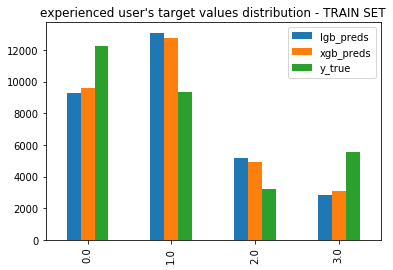

In [210]:
# train set 
y_true = y_train.value_counts()
y_true.name = 'y_true'
lgb_preds = pd.Series(reg_to_class(lgb_model[1].predict(X_train.drop(columns='installation_id').to_numpy()))).value_counts()
lgb_preds.name = 'lgb_preds'
xgb_preds = pd.Series(reg_to_class(xgb_model[1].predict(X_train.drop(columns='installation_id').to_numpy()))).value_counts()
xgb_preds.name = 'xgb_preds'

lgb_preds.to_frame().join(xgb_preds).join(y_true).sort_index().plot.bar()
plt.title("experienced user's target values distribution - TRAIN SET")
plt.show()

Text(0.5, 1.0, "experienced user's target values distribution - VALIDATION SET")

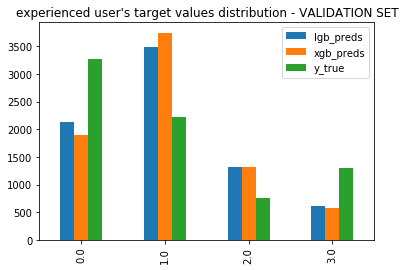

In [211]:
# test set
y_true = y_test.value_counts()
y_true.name = 'y_true'
lgb_preds = pd.Series(reg_to_class(lgb_model[1].predict(X_test.drop(columns='installation_id').to_numpy()))).value_counts()
lgb_preds.name = 'lgb_preds'
xgb_preds = pd.Series(reg_to_class(xgb_model[1].predict(X_test.drop(columns='installation_id').to_numpy()))).value_counts()
xgb_preds.name = 'xgb_preds'

lgb_preds.to_frame().join(xgb_preds).join(y_true).sort_index().plot.bar()
plt.title("experienced user's target values distribution - VALIDATION SET")
plt.show()

In [147]:
### New users ###
xgb_model_no_ass = train_xgb_new(X_train_no_ass, y_train_no_ass,
                             X_test_no_ass.drop(columns='installation_id'), y_test_no_ass)
lgb_model_no_ass = train_lgb_new(X_train_no_ass, y_train_no_ass,
                             X_test_no_ass.drop(columns='installation_id'), y_test_no_ass)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 18.9min finished


[22:55:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
cohen kappa score train:  0.8829759866372295
cohen kappa score test:  0.4004120380454512
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   41.4s finished


cohen kappa score train:  0.7406894792435917
cohen kappa score test:  0.45063107390964197


Text(0.5, 1.0, "new user's target values distribution - TRAIN SET")

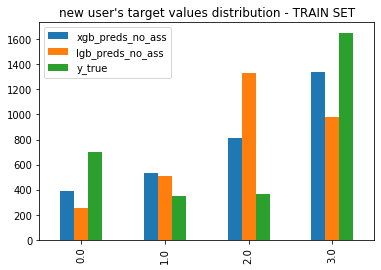

In [212]:
# train set
y_true_no_ass = y_train_no_ass.value_counts()
y_true_no_ass.name = 'y_true'
lgb_preds_no_ass = pd.Series(reg_to_class(lgb_model_no_ass[1].predict(X_train_no_ass.drop(columns='installation_id').to_numpy()))).value_counts()
lgb_preds_no_ass.name = 'lgb_preds_no_ass'
xgb_preds_no_ass = pd.Series(reg_to_class(xgb_model_no_ass[1].predict(X_train_no_ass.drop(columns='installation_id').to_numpy()))).value_counts()
xgb_preds_no_ass.name = 'xgb_preds_no_ass'

xgb_preds_no_ass.to_frame().join(lgb_preds_no_ass).join(y_true_no_ass).sort_index().plot.bar()
plt.title("new user's target values distribution - TRAIN SET")
plt.show()

Text(0.5, 1.0, "new user's target values distribution - VALIDATION SET")

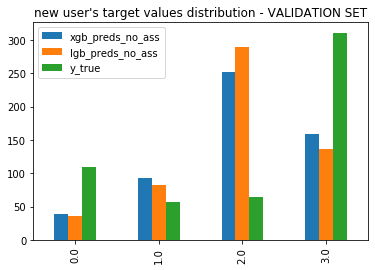

In [213]:
# test set
y_true_no_ass = y_test_no_ass.value_counts()
y_true_no_ass.name = 'y_true'
lgb_preds_no_ass = pd.Series(reg_to_class(lgb_model_no_ass[1].predict(X_test_no_ass.drop(columns='installation_id').to_numpy()))).value_counts()
lgb_preds_no_ass.name = 'lgb_preds_no_ass'
xgb_preds_no_ass = pd.Series(reg_to_class(xgb_model_no_ass[1].predict(X_test_no_ass.drop(columns='installation_id').to_numpy()))).value_counts()
xgb_preds_no_ass.name = 'xgb_preds_no_ass'

xgb_preds_no_ass.to_frame().join(lgb_preds_no_ass).join(y_true_no_ass).sort_index().plot.bar()
plt.title("new user's target values distribution - VALIDATION SET")
plt.show()

#### Expreienced Users Score:

In [235]:
# users with no assessments history perform worse

exp_lgbm = \
cohen_kappa_score(y_test.astype(int), 
                  reg_to_class(lgb_model[1].predict(X_test.drop(columns='installation_id').to_numpy())),
                  weights='quadratic')
exp_lgbm

0.6585534011039766

In [236]:
exp_xgb = \
cohen_kappa_score(y_test.astype(int), 
                  reg_to_class(xgb_model[1].predict(X_test.drop(columns='installation_id').to_numpy())),
                  weights='quadratic')
exp_xgb

0.6530678229774609

**Experienced users score perform well with both models.**

#### New Users Score:

In [233]:
# users with no assessments history perform worse

new_lgbm = \
cohen_kappa_score(y_test_no_ass.astype(int), 
                  reg_to_class(lgb_model_no_ass[1].predict(X_test_no_ass.drop(columns='installation_id').to_numpy())), 
                  weights='quadratic')
new_lgbm

0.45063107390964197

In [234]:
new_gxb = \
cohen_kappa_score(y_test_no_ass.astype(int), 
                  reg_to_class(xgb_model_no_ass[1].predict(X_test_no_ass.drop(columns='installation_id').to_numpy())), 
                  weights='quadratic')
new_gxb

0.4004120380454512

**In general prediction on new users perform worse. LGBM model is prefered.**

In [230]:
# checking for overfitting:

print('experienced users train score:',
     cohen_kappa_score(y_train.astype(int), 
                  reg_to_class(lgb_model[1].predict(X_train.drop(columns='installation_id').to_numpy())),
                  weights='quadratic'))
print('new users train score:',
     cohen_kappa_score(y_train_no_ass.astype(int), 
                  reg_to_class(lgb_model_no_ass[1].predict(X_train_no_ass.drop(columns='installation_id').to_numpy())), 
                  weights='quadratic'))

experienced users train score: 0.772429288334224
new users train score: 0.7406894792435917


**New users model is overfitted but I'll keep it as it is.**

### Mean Score - Experienced & New Users

In [237]:
# experienced / new users ratio 

exp_ratio = len(y_test) / len(y_train_no_ass)
exp_ratio

2.4601107131227615

In [247]:
# mean score

print(f'mean score: {(new_gxb + exp_ratio * exp_xgb) / (1 + exp_ratio):.3f}')

mean score: 0.580


**For comparison, the top 100 score was 0.547**.

# Test Set
I'll follow the same steps used on train set for setting the test set ready for predictions.

In [252]:
test = pd.read_csv('test.csv')

In [253]:
test.timestamp = pd.to_datetime(test.timestamp)
test['date'] = test.timestamp.dt.date 

In [254]:
test.head(2)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,date
0,27253bdc,0ea9ecc81a565215,2019-09-10 16:50:24.910000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,2019-09-10
1,27253bdc,c1ea43d8b8261d27,2019-09-10 16:50:55.503000+00:00,"{""event_code"": 2000, ""event_count"": 1}",00abaee7,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,2019-09-10


# Predicting Group Accuracy

### Apply new column for checking assessment success

In [255]:
event_test = test.loc[(((test.title=='Bird Measurer (Assessment)') & (test.event_code==4110)) |
                ((test.title!='Bird Measurer (Assessment)') & (test.event_code==4100)& 
                 (test.type=='Assessment'))),'event_data'].apply(lambda s: json.loads(s))

In [256]:
event_test.reset_index().join(pd.io.json.json_normalize(event_test).correct).set_index('index').drop(columns='event_data').head()

,correct
index,
303,True
1561,False
1569,True
1961,True
2333,False


In [257]:
test = test.join(event_test.reset_index().join(pd.io.json.json_normalize(event_test).correct).set_index('index').drop(columns='event_data'))

In [258]:
test.drop(columns='event_data', inplace=True)

# Calculating Agg. Features For Test Set

In [259]:
df_id_test = []
for name, group in test.groupby('installation_id', sort=False):

    ass = group.loc[(((group.title=='Bird Measurer (Assessment)') 
                                    & (group.event_code==4110)) |
                                        ((group.title!='Bird Measurer (Assessment)') 
                                         & (group.event_code==4100)& 
                                         (group.type=='Assessment')))]
        
#     total games time exp.
    test_date_id = []
    prev_game_per_date = group.loc[group.type=='Game'].groupby(['game_session','title'])['game_time'].max()
    total_game_time_id = prev_game_per_date.groupby('title').sum()
    total_game_time_id = total_game_time_id.to_frame().T
    total_game_time_id.index = [name] * len(total_game_time_id)
    total_game_time_id.columns = ['total_game_time_' + str(col) for col in total_game_time_id.columns]
    if total_game_time_id.shape[1]>0:
        test_date_id.append(total_game_time_id)
    else:
        pass

    prev_game_moves_per_date = group.loc[group.type=='Game'].groupby(['game_session','title'])['event_count'].max()
    total_game_moves_id = prev_game_moves_per_date.groupby('title').sum()
#         formating as line for df
    total_game_moves_id = total_game_moves_id.to_frame().T
    total_game_moves_id.index = [name] * len(total_game_moves_id)
    total_game_moves_id.columns = ['total_game_moves_' + str(col) for col in total_game_moves_id.columns]
    if total_game_moves_id.shape[1]>0:
        test_date_id.append(total_game_moves_id)
    else:
        pass
    
    prev_activity_per_date = group.loc[group.type=='Activity'].groupby(['game_session','title'])['game_time'].max()
    total_activity_time_id = prev_activity_per_date.groupby('title').sum()
#         formating as line for df
    total_activity_time_id = total_activity_time_id.to_frame().T
    total_activity_time_id.index = [name] * len(total_activity_time_id)
    total_activity_time_id.columns = ['total_activity_time_' + str(col) for col in total_activity_time_id.columns]
    if total_activity_time_id.shape[1]>0:
        test_date_id.append(total_activity_time_id)
    else:
        pass

    prev_activity_moves_per_date = group.loc[group.type=='Activity'].groupby(['game_session','title'])['event_count'].max()
    total_activity_moves_id = prev_activity_moves_per_date.groupby('title').sum()
#         formating as line for df
    total_activity_moves_id = total_activity_moves_id.to_frame().T
    total_activity_moves_id.index = [name] * len(total_activity_moves_id)
    total_activity_moves_id.columns = ['total_activity_moves_' + str(col) for col in total_activity_moves_id.columns]
    if total_activity_moves_id.shape[1]>0:
        test_date_id.append(total_activity_moves_id)
    else:
        pass

    prev_ass_per_date = group.loc[group.type=='Assessment'].groupby(['game_session','title'])['game_time'].max()
    total_ass_time_id = prev_ass_per_date.groupby('title').sum()
#         formating as line for df
    total_ass_time_id = total_ass_time_id.to_frame().T
    total_ass_time_id.index = [name] * len(total_ass_time_id)
    total_ass_time_id.columns = ['total_ass_time_' + str(col) for col in total_ass_time_id.columns]
    if total_ass_time_id.shape[1]>0:
        test_date_id.append(total_ass_time_id)
    else:
        pass

    prev_ass_moves_per_date = group.loc[group.type=='Assessment'].groupby(['game_session','title'])['event_count'].max()
    total_ass_moves_id = prev_ass_moves_per_date.groupby('title').sum()
#         formating as line for df
    total_ass_moves_id = total_ass_moves_id.to_frame().T
    total_ass_moves_id.index = [name] * len(total_ass_moves_id)
    total_ass_moves_id.columns = ['total_ass_moves_' + str(col) for col in total_ass_moves_id.columns]
    if total_ass_moves_id.shape[1]>0:
        test_date_id.append(total_ass_moves_id)
    else:
        pass
    
#         total ass. took
    total_ass_took = group.loc[group.type=='Assessment'].groupby(['title'])['game_session'].nunique()
    total_ass_took_id = total_ass_took.groupby('title').sum()
    total_ass_took_id = total_ass_took_id.to_frame().T
    total_ass_took_id[group.title.iloc[-1]] -= -1
    total_ass_took_id.index = [name] * len(total_ass_took_id)
    total_ass_took_id.columns = ['total_ass_took_' + str(col) for col in total_ass_took_id.columns]
    if total_ass_took_id.shape[1]>0:    
        test_date_id.append(total_ass_took_id)
    else:
        pass

#         total_days
    total_active_days = pd.DataFrame(data={name:[group.date.nunique()]}).T.rename(columns={0:'total_active_days'})
    test_date_id.append(total_active_days)

#         clips
    total_clips = pd.DataFrame(data={name:[group.loc[group.type=='Clip'].shape[0]]}).T.rename(columns={0:'total_clips'})
    test_date_id.append(total_clips)

#         cumsum game accuracy
    total_success = ass.loc[ass.correct==True, 'correct'].sum()

    total_tries = ass.shape[0]
    if total_tries==0:
        average_accuracy_score = 0
    else:
        average_accuracy_score = total_success / total_tries
    average_accuracy = pd.DataFrame(data={name:[average_accuracy_score]}).T.rename(columns={0:'cumsum_accuracy'})
    test_date_id.append(average_accuracy)        

#         total attempts per game
    if ass.shape[0]>0:
        attemps = ass.groupby(['title','game_session'])['correct'].count().groupby('title') 
        total_attemp = attemps.sum()
        total_attemp_df = total_attemp.to_frame().T
        try:
            total_attemp_df = total_attemp_df.drop(columns='total_clips')
        except:
            pass
        total_attemp_df.index = [name] * len(total_attemp_df)
        total_attemp_df.columns = ['total_attempts_' + str(col) for col in total_attemp_df.columns]
        test_date_id.append(total_attemp_df)        
    else:
        pass


#         average group_score by title
    if ass.shape[0]>0:
        avg_group_score = ass.groupby(['title','game_session'])['correct'].agg(true_attemp_num).apply(group_score)\
        .groupby('title').mean().to_frame().T
        avg_group_score.index = [name] * len(avg_group_score)
        avg_group_score.columns = ['avg_group_score_' + str(col) for col in avg_group_score.columns]
        test_date_id.append(avg_group_score) 
    else:
        pass

#         max_group_score
    if ass.shape[0]>0:
        max_group_score = attemps.max().apply(group_score).to_frame().T
        max_group_score.index = [name] * len(max_group_score)
        max_group_score.columns = ['max_group_score_' + str(col) for col in max_group_score.columns]
        test_date_id.append(max_group_score) 
    else:
        pass

#         prev_game_scores

    score_table = ass.groupby(['world','title','game_session'])['correct'].agg(['count','sum']).reset_index()
    score_table['group_score'] = 0
    score_table['accuracy'] = 0

    for row in range(score_table.shape[0]):
        if score_table.loc[row,'sum']==0:
            continue
        elif score_table.loc[row,'count'] == 1:
            score_table.loc[row,'group_score'] = 3
            score_table.loc[row,'accuracy'] =  (1 / score_table.loc[row,'count'])

        elif score_table.loc[row,'count'] > 2:
            score_table.loc[row,'group_score'] = 1
            score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])
        else:
            score_table.loc[row,'group_score'] = 2
            score_table.loc[row,'accuracy'] = (1 / score_table.loc[row,'count'])

    if score_table.shape[0]>0:

        group_accuracy_prev_games = score_table.groupby('title')['group_score','accuracy'].mean().T.iloc[1].to_frame().T
        group_accuracy_prev_games.index = [name] * len(group_accuracy_prev_games)
        group_accuracy_prev_games.columns = ['avg_accuracy_prev_games_' + str(col) for col in group_accuracy_prev_games.columns]
        test_date_id.append(group_accuracy_prev_games) 

        total_wins_prev_games = score_table.groupby('title')['sum'].sum().to_frame().T
        total_wins_prev_games.index = [name] * len(total_wins_prev_games)
        total_wins_prev_games.columns = ['total_wins_prev_games_' + str(col) for col in total_wins_prev_games.columns]
        test_date_id.append(total_wins_prev_games)         

        total_group_score_games = score_table.groupby(['title','group_score'])['game_session'].count().to_frame().T
        total_group_score_games.columns = [col[0] + '_group_' + str(col[1]) for col in total_group_score_games.columns.values]
        total_group_score_games.index = [name] * len(total_wins_prev_games)
        test_date_id.append(total_group_score_games) 

    #          total group accuracy history
        total_group_history = score_table.groupby('group_score')['title'].count().to_frame().T
        total_group_history.columns = ['group_'+str(col)+'_count' for col in total_group_history.columns.values]
        total_group_history.index = [name] * len(total_group_history)
        test_date_id.append(total_group_history) 

    #         accuracy in world ass.
        avg_world_accuracy = score_table.groupby('world')['accuracy'].mean().to_frame().T
        avg_world_accuracy.index = [name] * len(avg_world_accuracy)
        avg_world_accuracy.columns = ['avg_accuracy_world_' + str(col) for col in avg_world_accuracy.columns]
        test_date_id.append(avg_world_accuracy)

    #         group in world ass.
        avg_world_group = score_table.groupby('world')['group_score'].mean().to_frame().T
        avg_world_group.index = [name] * len(avg_world_group)
        avg_world_group.columns = ['avg_group_world_' + str(col) for col in avg_world_group.columns]
        test_date_id.append(avg_world_group)


    else:
        pass

    # first attemp in title
    if prev_game_scores.shape[0]>0:
        first_attempt = ~pd.DataFrame(prev_game_scores.index.str.contains(group.title.iloc[-1], regex=False)).any()
        first_attempt.index = [name] * len(first_attempt)
#         first_attempt.rename(columns={0:'first_attempt'},inplace=True)
        first_attempt.name = 'first_attempt'
        test_date_id.append(first_attempt) 
    else:
        test_date_id.append(pd.DataFrame([True], columns=['first_attempt'], index=[name]))
        
#         first attempt ever
    if ass.shape[0]==0:
        test_date_id.append(pd.DataFrame([True], columns=['first_ass'], index=[name]))
    else:
        test_date_id.append(pd.DataFrame([False], columns=['first_ass'], index=[name]))

#           games in world
    world_games = group.loc[(group.world!='NONE') & 
                      (group.type=='Game')].groupby(['world'])['game_session'].nunique().to_frame().T
    world_games.columns = ['total_games_'+str(col)+'_world' for col in world_games.columns.values]
    world_games.index = [name] * len(world_games)
    test_date_id.append(world_games) 

#         activities in world
    world_activity = group.loc[(group.world!='NONE') & 
                              (group.type=='Activity')].groupby(['world'])['game_session'].nunique().to_frame().T
    world_activity.columns = ['total_activities_'+str(col)+'_world' for col in world_activity.columns.values]
    world_activity.index = [name] * len(world_activity)
    test_date_id.append(world_activity) 


    
#         event codes counter

    event_codes_per_date = group.event_code.value_counts().to_frame().T
    event_codes_per_date.index = [name] * len(event_codes_per_date)
    event_codes_per_date.columns = ['event_code_' + str(col) for col in event_codes_per_date.columns]
    test_date_id.append(event_codes_per_date)


#         event id counter

    event_id_per_date = group.event_id.value_counts().to_frame().T
    try:
        event_id_per_date.drop(columns='27253bdc', inplace=True) # similar to clip counter
    except:
        pass
    event_id_per_date.index = [name] * len(event_id_per_date)
    event_id_per_date.columns = ['event_code_' + str(col) for col in event_id_per_date.columns]
    test_date_id.append(event_id_per_date)
    
    df_id_test.append(pd.concat(test_date_id, axis=1))



In [260]:
main_features_test = pd.concat(df_id_test).reset_index()
main_features_test.fillna(0, inplace=True)
print(main_features_test.shape)
# main_features_test.sample(10)

(1000, 526)


# Game Statistics

In [261]:
# same stats training set

game_stats

,accuracy,success_rate,overall_success_rate
title,,,
Bird Measurer (Assessment),0.387379,0.677349,0.166697
Cart Balancer (Assessment),0.742232,0.861238,0.533821
Cauldron Filler (Assessment),0.735537,0.896178,0.486610
Chest Sorter (Assessment),0.248625,0.412278,0.123307
Mushroom Sorter (Assessment),0.711042,0.841895,0.505352


# Constructing the test set

In [262]:
last_action = test.loc[test.reset_index().groupby('installation_id')['index'].last()]
last_action.head(2)

,event_id,game_session,timestamp,installation_id,event_count,event_code,game_time,title,type,world,date,correct
867,90d848e0,348d7f09f96af313,2019-09-12 13:52:12.193000+00:00,00abaee7,1,2000,0,Cauldron Filler (Assessment),Assessment,MAGMAPEAK,2019-09-12,NaN
3586,7ad3efc6,1fef5d54cb4b775a,2019-10-09 20:23:16.209000+00:00,01242218,1,2000,0,Cart Balancer (Assessment),Assessment,CRYSTALCAVES,2019-10-09,NaN


In [263]:
last_action['hour_of_day'] = last_action.timestamp.dt.hour
last_action['weekday'] = last_action.timestamp.dt.weekday

last_action['sin_time'] = np.sin(2 * np.pi * last_action.hour_of_day/24)
last_action['cos_time'] = np.cos(2 * np.pi * last_action.hour_of_day/24)
last_action['sin_weekday'] = np.sin(2 * np.pi * last_action.weekday/7)
last_action['cos_weekday'] = np.cos(2 * np.pi * last_action.weekday/7)

last_action.drop(columns=['hour_of_day','weekday','date'], inplace=True)

In [264]:
print(last_action.shape)
test_agg = last_action.merge(main_features_test, how='left', left_on=['installation_id'],
             right_on=['index'])
print(test_agg.shape)

(1000, 15)
(1000, 541)


In [265]:
test_agg = test_agg.merge(game_stats, left_on='title', right_index=True,
                             how='left')
print(test_agg.shape)

(1000, 544)


In [266]:
test_agg_clean = test_agg.drop(columns=['timestamp', 'game_session',
                                        'type', 'index', 'correct',
                                         'event_code','event_id',
                                       'event_count','game_time'])
test_agg_clean.shape

(1000, 535)

In [267]:
test_agg_clean_dummies = pd.get_dummies(test_agg_clean, columns=['world','title'])
test_agg_clean_dummies.shape

(1000, 541)

In [268]:
# removing highly correlated columns as for the train set

for col in cols_to_remove_corr:
    try:
        test_agg_clean_dummies.drop(columns=col, inplace=True)
    except:
        pass
test_agg_clean_dummies.shape

(1000, 426)

In [269]:
len(model_col_list), test_agg_clean_dummies.shape[1]

(440, 426)

**Using col_list from train label to complete to main_features attributes**

In [270]:
for col in model_col_list:
    if col in (test_agg_clean_dummies.columns):
        pass
    else:
        test_agg_clean_dummies[col] = 0

In [271]:
test_agg_clean_dummies.set_index('installation_id', inplace=True)
test_agg_clean_dummies.fillna(0, inplace=True)

In [272]:
# the difference is ok
model_col_list[~model_col_list.isin(test_agg_clean_dummies)]

Index(['installation_id'], dtype='object')

In [273]:
test_agg_clean_dummies.columns[~test_agg_clean_dummies.columns.isin(model_col_list)]

Index([], dtype='object')

In [274]:
#  changing into the right types as in the train set:

for col in test_agg_clean_dummies.columns:
    if col!='first_ass':
        test_agg_clean_dummies[col] = test_agg_clean_dummies[col].astype(train_agg_clean_dummies[col].dtype)

In [275]:
test_agg_clean_dummies.head()

,sin_time,cos_time,sin_weekday,cos_weekday,Bird Measurer (Assessment)_group_0,Bird Measurer (Assessment)_group_1,Bird Measurer (Assessment)_group_2,Bird Measurer (Assessment)_group_3,Cart Balancer (Assessment)_group_0,Cart Balancer (Assessment)_group_1,...,event_code_1b54d27f,event_code_29a42aea,event_code_2ec694de,event_code_611485c5,event_code_7fd1ac25,event_code_ab4ec3a4,event_code_bfc77bd6,event_code_e4d32835,event_code_ecc6157f,accuracy_group
installation_id,,,,,,,,,,,,,,,,,,,,,
00abaee7,-0.258819,-9.659258e-01,0.433884,-0.900969,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01242218,-0.866025,5.000000e-01,0.974928,-0.222521,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
017c5718,0.258819,-9.659258e-01,-0.974928,-0.222521,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01a44906,-0.866025,-5.000000e-01,-0.974928,-0.222521,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01bc6cb6,-1.000000,-1.836970e-16,-0.433884,-0.900969,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
del test_agg
del last_action
del test_agg_clean
del main_features_test
del df_id_test
gc.collect()

22

In [277]:
test_no_ass_index = test_agg_clean_dummies.loc[test_agg_clean_dummies.first_ass==True].index

In [278]:
# cols order:

cols_order = train_agg_clean_dummies.columns.tolist()
test_agg_clean_dummies = test_agg_clean_dummies.loc[:, cols_order]
test_agg_clean_dummies.drop(columns=['accuracy_group','installation_id'], inplace=True)

# Make Predictions 

## Experienced Users:

In [279]:
# varify that each column in the train set is also in test set
(X_train.drop(columns='installation_id').columns == test_agg_clean_dummies.columns).all()

True

In [280]:
test_w_ass_index = test_agg_clean_dummies.loc[~test_agg_clean_dummies.index.isin(test_no_ass_index)].index

In [281]:
y_test_score_pred_xgb = xgb_model[1].predict(test_agg_clean_dummies.loc[test_w_ass_index].to_numpy())
y_test_score_pred_lgb = lgb_model[1].predict(test_agg_clean_dummies.loc[test_w_ass_index].to_numpy())

In [282]:
y_test_score_pred_class = reg_to_class(y_test_score_pred_xgb*0.15 + y_test_score_pred_lgb*0.85)
pd.Series(y_test_score_pred_class).value_counts().sort_index()

0.0     40
1.0    154
2.0    240
3.0    123
dtype: int64

In [283]:
submission_w_ass = pd.DataFrame(data=y_test_score_pred_class, 
                                 index=test_w_ass_index).rename(columns={0:'accuracy_group'})
submission_w_ass.head()    

,accuracy_group
installation_id,
00abaee7,2.0
01242218,3.0
02256298,3.0
027e7ce5,2.0
02a29f99,0.0


## New Users

In [284]:
relevant_col_no_ass = train_agg_clean_dummies_no_ass.columns.to_list()
relevant_col_no_ass.remove('installation_id')
relevant_col_no_ass.remove('accuracy_group')

In [285]:
relevant_col_no_ass[:5]

['event_code_0086365d',
 'event_code_00c73085',
 'event_code_022b4259',
 'event_code_02a42007',
 'event_code_05ad839b']

In [286]:
y_test_score_pred_no_ass_xgb = \
xgb_model_no_ass[1].predict(test_agg_clean_dummies.loc[test_no_ass_index, relevant_col_no_ass].to_numpy())
y_test_score_pred_no_ass_lgb = \
lgb_model_no_ass[1].predict(test_agg_clean_dummies.loc[test_no_ass_index, relevant_col_no_ass].to_numpy())

In [287]:
test_agg_clean_dummies.loc[test_no_ass_index, relevant_col_no_ass].shape

(443, 356)

In [288]:
y_test_score_pred_no_ass_class = reg_to_class(y_test_score_pred_no_ass_xgb*0.6 + y_test_score_pred_no_ass_lgb*0.4)
pd.Series(y_test_score_pred_no_ass_class).value_counts().sort_index()

0.0     20
1.0     73
2.0    229
3.0    121
dtype: int64

In [289]:
submission_no_ass = pd.DataFrame(data=reg_to_class(y_test_score_pred_no_ass_class), 
                                 index=test_no_ass_index).rename(columns={0:'accuracy_group'})
submission_no_ass.head()                                                                                                  

,accuracy_group
installation_id,
017c5718,3.0
01a44906,3.0
01bc6cb6,3.0
0267757a,2.0
0300c576,2.0
